#**ECE 4554/ ECE 5554 / Computer Vision**
This file contains Machine Problems 1 and 2, which comprise the coding portion of Homework 3. Your job is to implement/modify the sections within this notebook that are marked with "TO DO".

##**TO DO**: Enter your Virginia Tech Username (PID) here: ankitparekh 

##**Honor Code reminder**

This is not a "team project". Please review the Honor Code statement in the syllabus.  

##**Submission guidelines** for the coding problems (Google Colab)

1. Please verify that you have entered your Virginia Tech Username in all of the appropriate places.
2. After clicking Runtime->Run all, verify that all of your solutions are visible in this notebook.
3. Click File->Save near the top of the page to save the latest version of your notebook at Google Drive.
4. Verify that the last 2 cells have executed, creating a PDF version of this notebook at Google Drive. (Note: if you face difficulty with this step, please refer to https://pypi.org/project/notebook-as-pdf/)
5. Look at the PDF file and check that all of your solutions are displayed correctly there.
6. Download your notebook file and the PDF version to your laptop.
7. On your laptop, create a ZIP version of this notebook file. (Please don't include the separate data files.) Use file name Homework3_Code_USERNAME.zip, with your own Username.
6. For your PDF version, use file name Homework3_Notebook_USERNAME.pdf, with your own Username.
7. **Submit these 2 files and your PDF file for Problems 1-4 SEPARATELY to Canvas.** Do not zip them all together.

##**Overview**

For Machine Problem 1, you will write code to find a 2D homography and to perform image warping.

Machine Problem 2 requires you to use your code from the first problem to create an image mosaic. 

# Environment setup

In [1]:
# Mount your Google Drive to this notebook
# The purpose is to allow your code to access to your files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change the directory to your own working directory
# Any files under your working directory are available to your code
# TO DO: enter the name of your directory
import os
os.chdir('/content/drive/My Drive/5554/HW3')

In [3]:
# Import library modules
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
# PIL is the Python Imaging Library
from PIL import Image  
# The following is a substitute for cv2.imshow,
#  which you would use on your local machine but Colab does not support it
from google.colab.patches import cv2_imshow

print('Python version:', sys.version)
print('OpenCV version:', cv2.__version__)
print('NumPy version: ', np.__version__)


Python version: 3.7.14 (default, Sep  8 2022, 00:06:44) 
[GCC 7.5.0]
OpenCV version: 4.6.0
NumPy version:  1.21.6


#Getting started

Several image files were provided to you (mandrill.tif, Rubiks_cube.jpg, wall*.png). Upload all of them to your working directory.

The following functions are helpful for loading images into floating-point format, and for displaying images that are in that format.  Let's use those functions to visualize two separate images that we want to stitch together later in this assignment. Notice that you can adjust the size of the figure that is displayed.


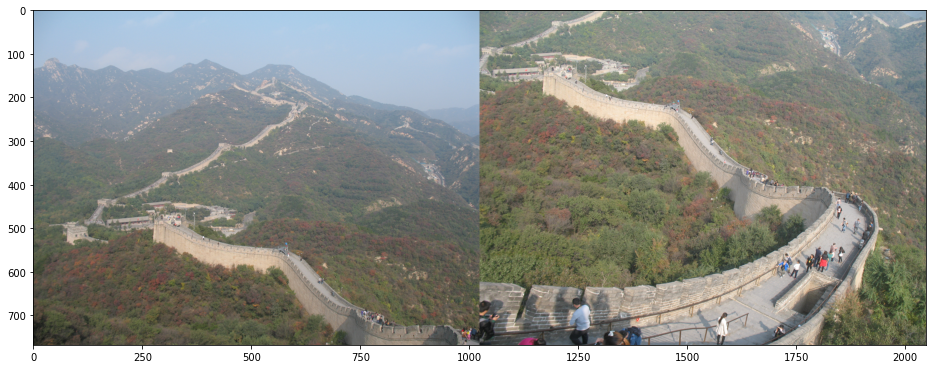

In [4]:
def load_image(filename):
  img = np.asarray(Image.open(filename))
  img = img.astype("float32")/255.0
  return img

def show_image(img):
  fig = plt.figure()
  fig.set_size_inches(16, 12) # You can adjust the size of the displayed figure
  plt.imshow(img)

left_img = load_image("wall1.png")
right_img = load_image("wall2.png")
show_image(np.concatenate([left_img,  right_img], axis=1))

#Machine Problem 1 (10 points)
**a) 2D homography**

Implement the 2 functions that are shown in the next code block. (OpenCV has a findHomography() function and other related functions, but for this assignment you must write your own versions.)

1.   **compute_homography(src, dst)** receives two matrices, each of size Nx2. Each matrix contains N two-dimensional points. For each value of i, src[i] and dst[i] are corresponding points from two different images. The function should return the homography matrix H of size 3x3 that maps every point from the source (src) to the destination (dst).   Guidance: You may assume that N is at least 4. You can set up the problem in a matrix-based, least-squares format. (A somewhat similar problem is in the lecture slides on page 15 of packet 9.) Helpful functions are `np.linalg.eig()` and `np.linalg.eigh()` for computing eigenvalues and eigenvectors. The latter function will prevent warnings due to small imaginary values if you are working with matrices that are real and symmetric. 
2.   **apply_homography(src, H)** receives points in matrix named src (an Nx2 matrix), and a homography transformation H (a 3x3 matrix). This function should use the homography matrix to transform each point in src to a new destination point. Store the resulting points in matrix dst, which is the same size as src. The function should return dst. Guidance: remember to use homogeneous coordinates when implementing this transformation.



In [5]:
##############################
# TO DO: Implement the compute_homography function

def compute_homography(src, dst):
  '''Computes the homography from src to dst.
   Input:
    src: source points, shape (N, 2), where N >= 4
    dst: destination points, shape (N, 2)
   Output:
    H: homography from source points to destination points, shape (3, 3)  
  '''
  
  number_of_points, number_of_dimensions = src.shape[0], src.shape[1]
  src = np.array(src)
  dst = np.array(dst)
  # Solution for Homography is an eigen value problem [transpose(Q).Q.a =  λ.a]

  #Initializing Q with zeros
  Q = np.zeros([2*number_of_points, (number_of_dimensions + 1)**2])
  #print(Q)

  rows, columns = Q.shape[0], Q.shape[1]
  # Filling Q with the respective values 
  for i in range(rows):
    pt = i//2
    xs, ys = src[pt][0], src[pt][1]
    xd, yd = dst[pt][0], dst[pt][1] 
    if i % 2 == 0:
      Q[i] = [xs, ys, 1, 0, 0, 0, -1*xd*xs, -1*xd*ys, -1*xd]
    else:
      Q[i] = [0, 0, 0, xs, ys, 1, -1*yd*xs, -1*yd*ys, -1*yd]
  #print(Q)

  # Solving Eigen value problem for Q
  matrix = np.matmul(np.transpose(Q), Q)
  eigen_values = np.linalg.eigh(matrix)[0]
  #eigen_vectors = np.transpose(np.linalg.eigh(matrix)[1])
  min_eigen_value = min(eigen_values)
  idx_min_eigen_value = eigen_values.tolist().index(min_eigen_value)
  eigen_vector = np.linalg.eigh(matrix)[1][:, idx_min_eigen_value]
  H = np.array([eigen_vector[0:3],eigen_vector[3:6], eigen_vector[6:9]])
  #print(H)
  return H

##############################
# TO DO: Implement the apply_homography function

def apply_homography(src, H):
  '''Applies a homography H to the source points.
   Input:
      src: source points, shape (N, 2)
      H: homography from source points to destination points, shape (3, 3)
   Output:
     dst: destination points, shape (N, 2)
  '''
  
  rows, columns = src.shape[0], src.shape[1]
  dst = np.zeros([rows, columns])
  # Iterating over each point
  #src = np.array(src)
  # for i in range(len(src)):
  #   x = np.transpose(np.append(src[i], 1))
  #   matrix = np.matmul(H, x)
  #   dst[i] = np.transpose(matrix)[:-1]/matrix[2]
  
  # Complete Matrix Multiplication
  x = np.concatenate((src, np.array([[1]*rows]).T), axis=1)
  dst = np.matmul(H, np.transpose(x))
  dst = dst/dst[2]
  dst = np.transpose(dst[:-1,:])

  return dst

You do not need to change the following code block. It will test your homography code, and should help you in debugging. Corresponding points are placed in src_pts and dst_pts. If your homography code is correct, it should map the points given in test_pts to locations that are close to the points given in match_pts_correct. If you have correctly implemented compute_homography() and apply_homography(), then the printed difference values should be close to 0. (For full credit, the reported difference should be no larger than 0.001.)

In [6]:
def test_homography():
  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1')
  dst_pts = np.matrix('3, 2; 3.67, 2; 3.5, 2.5; 3, 3')
  H = compute_homography(src_pts, dst_pts)
  test_pts = src_pts 
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = dst_pts 
  print('Your 1st solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())
  
  src_pts = np.matrix('0, 0; 1, 0; 1, 1; 0, 1; 2, 3')
  dst_pts = np.matrix('3, 2; 3.67, 2; 3.5, 2.5; 3, 3; 3.5, 2.75')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('0,  0; 1, 0; 1, 1; 0, 1')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('3, 2; 3.66666667, 2; 3.5, 2.5; 3, 3')
  print('Your 2nd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())
  
  src_pts = np.matrix('347, 313; 502, 341; 386, 571; 621, 508')
  dst_pts = np.matrix('274, 286; 436, 305; 305, 527; 615, 506')
  H = compute_homography(src_pts, dst_pts)
  test_pts = np.matrix('259, 505; 350, 371; 400, 675; 636, 104')
  match_pts = apply_homography(test_pts, H)
  match_pts_correct = np.matrix('195.13761083, 448.12645033;'
    '275.27269386, 336.54819916;'
    '317.37663747, 636.78403426;'
    '618.50438823, 28.78963905')
  print('Your 3rd solution differs from our solution by: %f'
    % np.square(match_pts - match_pts_correct).sum())

test_homography()

Your 1st solution differs from our solution by: 0.000000
Your 2nd solution differs from our solution by: 0.000009
Your 3rd solution differs from our solution by: 0.000011


**b)  Image warping using a 2D homography**

Implement the following function so that it performs image warping from a source image (src_img) to a newly created destination image (dst_img). Do not use any additional OpenCV functions. The homography H that is provided indicates a desired mapping from src_img to dst_img. To prevent gaps in the output image, however, it is suggested that your implementation should iterate over all pixels in dst_img. In that case, your code should use the *inverse* of H to find values in src_img as it iterates over dst_img.

In [7]:
##############################
# TO DO: Implement the warp_img function

def warp_img(src_img, H, dst_img_size):
  '''Warping of a source image using a homography.
   Input:
      src_img: source image with shape (m, n, 3)
      H: homography, with shape (3, 3), from source image to destination image
      dst_img_size: height and width of destination image; shape (2,)
   Output:
      dst_img: destination image; height and width specified by dst_img_size parameter
  '''
  
  rows, columns = dst_img_size[0], dst_img_size[1]
  dst_img = np.zeros([rows, columns, 3])
  h_inv = np.linalg.inv(H)

  src_img_rows, src_img_columns = src_img.shape[0], src_img.shape[1]

  for row in range(rows):
    for column in range(columns):
      dst_pt = np.array([[row, column]])
      src_pt = apply_homography(dst_pt, h_inv)
      xs, ys = int(src_pt[0, 0]), int(src_pt[0, 1])
      if (xs>=0 and xs<src_img_rows) and (ys>=0 and ys<src_img_columns):
        dst_img[row, column] = src_img[xs, ys]

  return dst_img

The following code block will test your image_warp function by performing a  rotation. You do not need to change any code in the following block. If your code is correct, the output here should show a mandrill image that has been rotated by 15 degrees counterclockwise about the upper-left corner. 


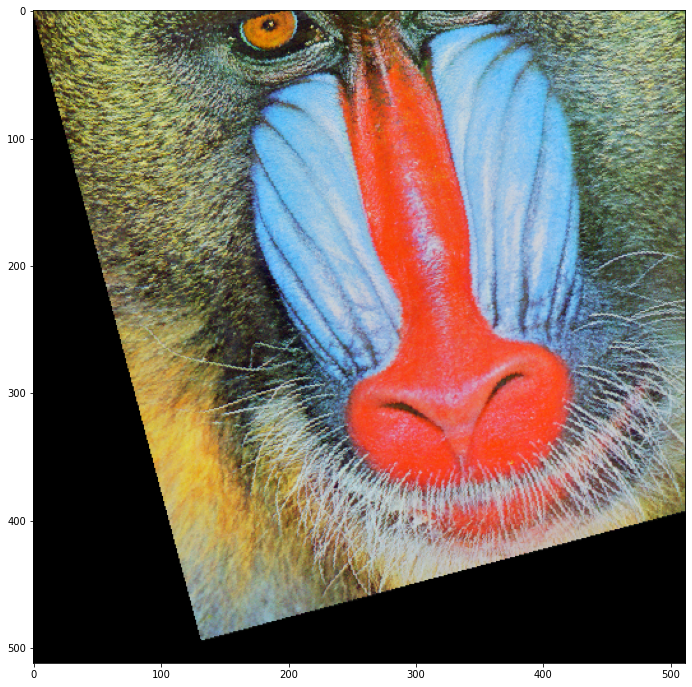

In [8]:
def test_rotation():
  src_img = load_image('mandrill.tif')
  canvas_img = np.zeros([src_img.shape[0], src_img.shape[1], 3])

  theta = 15  # counterclockwise rotation angle in degrees  
  H = [[np.cos(theta * np.pi/180), -np.sin(theta * np.pi/180), 0.0],
       [np.sin(theta * np.pi/180), np.cos(theta * np.pi/180), 0.0],
       [0.0, 0.0, 1.0]]
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])
  show_image(dst_img)

test_rotation()

The following will test your image_warp function with a more general homography. You do not need to modify these functions. If your code is correct, the output here should show a  mandrill image that has been warped to overlay the blue side of a Rubik's cube.

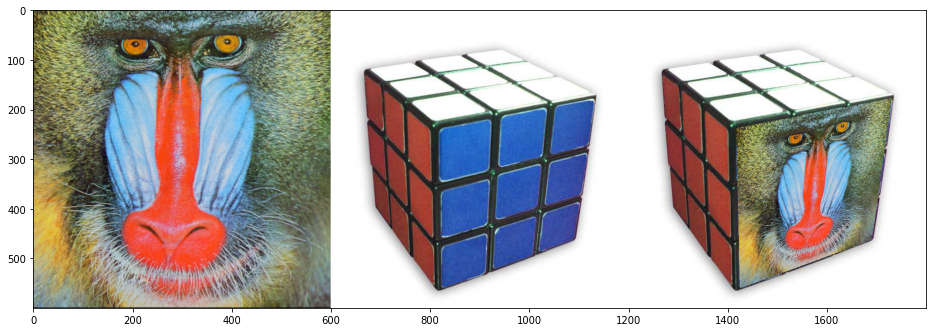

In [9]:
def binary_mask(img):
  '''Create a binary mask of the image content.
   Input:
    img: source image, shape (m, n, 3)
   Output:
    mask: image of shape (m, n) and type 'int'. For pixel [i, j] of mask, 
      if pixel [i, j] in img is nonzero in any channel, assign 1 to mask[i, j]. 
      Else, assign 0 to mask[i, j].
  '''
  mask = (img[:, :, 0] > 0) | (img[:, :, 1] > 0) | (img[:, :, 2] > 0)
  mask = mask.astype("int")
  return mask

def test_warp():
  src_img = load_image('mandrill.tif')
  canvas_img = load_image('Rubiks_cube.jpg')

  # The following are corners of the mandrill image in (ROW, COLUMN) order
  src_pts = np.matrix('0, 0; 511, 0; 511, 511; 0, 511')
  # The following are corners of the blue face of the Rubik's cube
  canvas_pts = np.matrix('238, 218; 560, 225; 463, 490; 178, 530')

  # The following was used during debugging
  # It draws a circle at a location specified by (COLUMN, ROW)
  # cv2.circle(canvas_img, (530, 178), 4, (255, 0, 0), thickness=10)

  H = compute_homography(src_pts, canvas_pts)
  dst_img = warp_img(src_img, H, [canvas_img.shape[0], canvas_img.shape[1]])
  dst_mask = 1 - binary_mask(dst_img)
  dst_mask = np.stack((dst_mask,) * 3, -1)
  out_img = np.multiply(canvas_img, dst_mask) + dst_img
  
  dsize = (600, 600) # width and height of canvas_im
  src_smaller = cv2.resize(src_img, dsize, interpolation=cv2.INTER_AREA)
  
  warped_img = np.concatenate((src_smaller, canvas_img, out_img), axis=1)
  show_image(np.clip(warped_img, 0, 1))

test_warp()

#Machine Problem 2 (10 points)

Write a function called stitch_img() that will create and display a panorama from the two 'wall' images that were shown at the beginning of this notebook. The stitch_img() function should open the two images and then stitch them together to construct one larger composite image. You may hard-code the file names inside this function.

Your code should perform image warping using a homography for one of the images, so that overlapping portions of the two are well aligned. For example, you might perform image warping for wall2.png in a way that allows your code to merge this new warped image along with wall1.png into a composite image. For full credit, write your function so that the final composite image is shown at a reasonable scale, and does not truncate any of the border portions of the two input images. 

Your stitch_img function must use your functions from Machine Problem 1 (compute_homography and apply_homography) to create the panorama. You must use 4 or more  pairs of corresponding points from the 2 images, and stitch_image must invoke compute_homography to determine the homography that is used to perform image warping. (You are allowed to find the corresponding points manually, and hard-coded them into your solution. Automatic keypoint detection is not required in this assignment.)

Note that we do not expect the final composite image to be perfect, partly because lens distortion is likely to prevent the homography from aligning things perfectly. However, try to write code that will stitch the images together in a reasonable way.

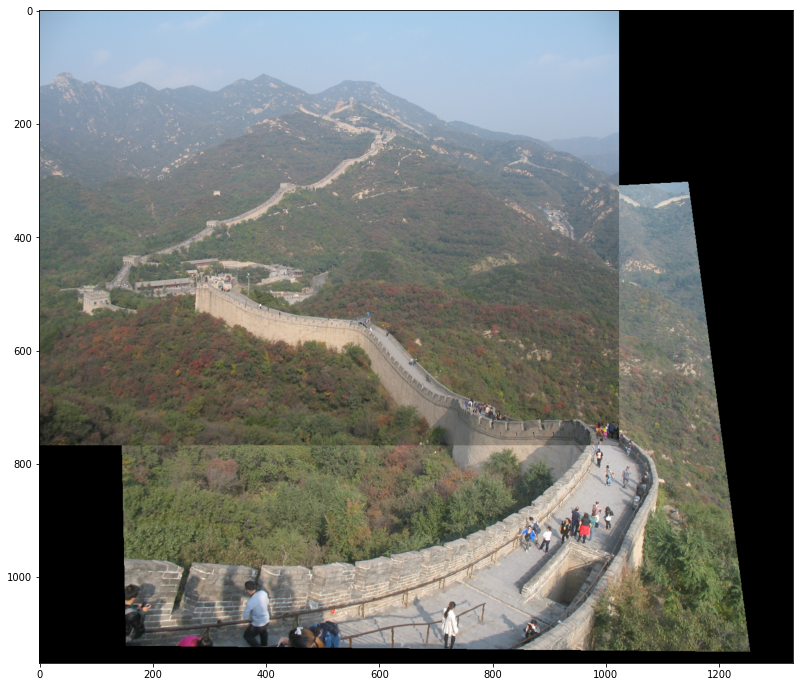

In [10]:
##############################
# TO DO: Implement the stitch_img function

def stitch_img():
  '''Create and display a composite image.
   Input parameters:
    none
   Returned value:
    none
  '''
  # Computing homography
  # Using wall1.png as destination image
  # Using wall2.png as source image for warping
  # Initializing key-point pairs for the two images
  src_pts = np.matrix('226, 399; 224, 382; 170, 326; 210, 455; 129, 244; 135, 108; 330, 522; 345, 542')
  dst_pts = np.matrix('557, 525; 555, 508; 503, 450; 537, 580; 467, 370; 478, 241; 657, 656; 670, 678')
  H = compute_homography(src_pts, dst_pts)
  
  # Getting warped image
  src_img = load_image('wall2.png')
  dst_img = load_image('wall1.png')
  dst_img_size = [int(1.5*dst_img.shape[0]), int(1.3*dst_img.shape[1])]
  warped_img = warp_img(src_img, H, dst_img_size)
  
  #Overlaying canvas (dst_img) onto warped image
  warped_img[0:src_img.shape[0], 0:src_img.shape[1]] = dst_img
  show_image(warped_img)

stitch_img()

---
# Creating a PDF version of your current notebook

In [11]:
#The following two installation steps are needed to generate a PDF version of the notebook
#(These lines are needed within Google Colab, but are not needed within a local version of Jupyter notebook)
!apt-get update
!apt-get -qq install texlive texlive-xetex texlive-latex-extra pandoc 
!pip install --quiet pypandoc

Hit:1 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:9 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Reading package lists... Done


In [12]:
# TO DO: Provide the full path to your Jupyter notebook file
!jupyter nbconvert --to PDF "/content/drive/MyDrive/5554/HW3/Homework3_ankitparekh.ipynb"

[NbConvertApp] Converting notebook /content/drive/MyDrive/5554/HW3/Homework3_ankitparekh.ipynb to PDF
[NbConvertApp] Support files will be in Homework3_ankitparekh_files/
[NbConvertApp] Making directory ./Homework3_ankitparekh_files
[NbConvertApp] Making directory ./Homework3_ankitparekh_files
[NbConvertApp] Making directory ./Homework3_ankitparekh_files
[NbConvertApp] Writing 60113 bytes to ./notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', './notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', './notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 1752025 bytes to /content/drive/MyDrive/5554/HW3/Homework3_ankitparekh.pdf
